# **IT Incident Management (ABC Tech)**

## Problem Statement

1. **Predicting High Priority Tickets:**  
   Predict whether a ticket will be Priority 1 or Priority 2 so proactive measures can be taken before issues escalate.

2. **Forecasting Incident Volume:**  
   Forecast incident volume across different domains (quarterly and annual) to enable better planning of resources and technology.

3. **Auto-Tagging Tickets:**  
   Automatically assign the correct `Priority` and `CI_Cat` (department/category) to reduce ticket reassignment delays.

4. **Predicting RFC & Asset Misconfigurations:**  
   Identify tickets likely to be linked with Request for Change (RFC) or misconfigured ITSM assets to prevent potential failures.

---

## Project Description

### Business Case:

ABC Tech is a mid-sized IT services company with over 10 years of operational experience. They handle around 22,000–25,000 incident tickets annually and follow established **ITIL-based ITSM processes** such as incident, change, problem, and configuration management. These processes have matured over time, reaching a high level of operational efficiency.

However, a recent audit revealed diminishing ROI from traditional process improvement initiatives. At the same time, customer satisfaction surveys indicated **poor performance in incident management**, highlighting an opportunity for data-driven enhancements.

To address these challenges, ABC Tech’s leadership has chosen to adopt **Machine Learning (ML)** solutions aimed at optimizing their ITSM workflows. After participating in a domain-specific ML conference, they shortlisted four high-impact use cases where ML can enhance IT operations.

---

## Machine Learning Use Cases at ABC Tech

1. **High-Priority Ticket Prediction**  
   Classify incoming tickets into high-priority (P1/P2) or normal (P3/P4) to enable proactive alerting and early resource allocation.

2. **Incident Volume Forecasting**  
   Predict ticket volumes across departments and timeframes (quarterly, yearly) to support strategic planning and staffing.

3. **Ticket Auto-Tagging**  
   Auto-classify tickets with the correct **priority level** and **CI_Cat** (department) using available ticket metadata to improve routing and reduce manual effort.

4. **RFC & Asset Misconfiguration Prediction**  
   Predict if a ticket is linked to a failed change or a misconfigured IT asset, helping teams prevent outages and configuration drift.

---

## Dataset Overview

The data consists of ~46,000 incident records from 2012–2014 stored in a MySQL database. Key features include:

- `CI_Name`, `CI_Cat`, `CI_Subcat` – Configuration Item details  
- `Incident_ID`, `Status`, `Priority`, `Impact`, `Urgency`, `Category` – Ticket metadata  
- `No_of_Reassignments`, `Handle_Time_hrs` – Operational KPIs  
- `Closure_Code`, `KB_number`, `Alert_Status` – Closure and knowledge base info  
- `Open_Time`, `Resolved_Time`, `Close_Time` – Time-based logs  
- `No_of_Related_Incidents`, `No_of_Related_Changes`, `Related_Change` – Incident/change relations  

This dataset provides rich context for building robust predictive models tailored to real-world ITSM challenges.


# Imports

In [1]:
import mysql.connector as mysql
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc,make_scorer, f1_score
)
from datetime import datetime
from imblearn.over_sampling import SMOTENC
from collections import Counter


# Database Connection

In [ ]:
connection = mysql.connect(
  # SERVER DETAILS HAS BEEN HIDDEN DUE TO PRIVACY 
)

In [3]:
a=pd.read_sql_query(' show tables ',connection)
print(a)

  Tables_in_project_itsm
0           dataset_list


In [4]:
df=pd.read_sql_query('select * from dataset_list ',connection)


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [6]:
df.head(10)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,,
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,,
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,,,
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,,,
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,,,
5,WBA000124,application,Web Based Application,WBS000088,IM0000013,Closed,4,4,4,0.006675648,incident,KM0000611,closed,4,10-08-2012 11:27,,08-11-2013 13:54,08-11-2013 13:54,"3,38,34,36,944",Other,1,SD0000031,,,
6,WBA000082,application,Web Based Application,WBS000055,IM0000014,Closed,4,4,4,0.19290712,incident,KM0000401,closed,2,15-08-2012 14:17,,27-12-2013 10:59,27-12-2013 10:59,"3,70,31,91,389",Unknown,1,SD0000033,,,
7,WBA000124,application,Web Based Application,WBS000088,IM0000015,Closed,4,4,4,0.996467545,incident,KM0000611,closed,5,22-08-2012 16:31,,08-11-2013 14:09,08-11-2013 14:09,"3,29,46,24,167",Other,1,SD0000034,,,
8,WBA000124,application,Web Based Application,WBS000088,IM0000017,Closed,NS,3,NA,0.269573825,incident,KM0000611,closed,2,29-08-2012 15:59,,08-11-2013 14:02,08-11-2013 14:02,"0,862777778",Other,1,SD0000036,,,
9,WBA000082,application,Web Based Application,WBS000055,IM0000018,Closed,4,4,4,0.306670312,incident,KM0000401,closed,2,03-09-2012 16:04,,08-11-2013 14:33,08-11-2013 14:35,"3,21,15,26,944",No error - works as designed,1,SD0000037,,,


# PRECHECKS

In [7]:
df.shape

(46606, 25)

In [8]:
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,,
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,,
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,,,
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,,,
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,,,


In [9]:
df.tail()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
46601,SBA000464,application,Server Based Application,WBS000073,IM0047053,Closed,4,4,4,0.23189604,incident,KM0001314,closed,0,31-03-2014 16:23,,31-03-2014 16:29,31-03-2014 16:29,"0,095",Other,1,SD0147021,,,
46602,SBA000461,application,Server Based Application,WBS000073,IM0047054,Closed,4,4,4,0.805153085,incident,KM0002360,closed,0,31-03-2014 15:03,,31-03-2014 15:29,31-03-2014 15:29,"0,428333333",User error,1,SD0146967,,,
46603,LAP000019,computer,Laptop,WBS000091,IM0047055,Closed,5,5,5,0.917466294,incident,KM0000315,closed,0,31-03-2014 15:28,,31-03-2014 15:32,31-03-2014 15:32,"0,071666667",Hardware,1,SD0146982,,,
46604,WBA000058,application,Web Based Application,WBS000073,IM0047056,Closed,4,4,4,0.701278158,incident,KM0001287,closed,0,31-03-2014 15:35,,31-03-2014 15:42,31-03-2014 15:42,"0,116944444",Software,1,SD0146986,,,
46605,DCE000077,hardware,DataCenterEquipment,WBS000267,IM0047057,Closed,3,3,3,0.902319509,incident,KM0000182,closed,0,31-03-2014 17:24,,31-03-2014 22:47,31-03-2014 22:47,"0,586388889",Hardware,1,SD0147088,,,


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   CI_Name                     46606 non-null  object
 1   CI_Cat                      46606 non-null  object
 2   CI_Subcat                   46606 non-null  object
 3   WBS                         46606 non-null  object
 4   Incident_ID                 46606 non-null  object
 5   Status                      46606 non-null  object
 6   Impact                      46606 non-null  object
 7   Urgency                     46606 non-null  object
 8   Priority                    46606 non-null  object
 9   number_cnt                  46606 non-null  object
 10  Category                    46606 non-null  object
 11  KB_number                   46606 non-null  object
 12  Alert_Status                46606 non-null  object
 13  No_of_Reassignments         46606 non-null  ob

###  INSIGHT :

In the dataset, all columns are currently stored as `object` type, which is not appropriate for many columns.  
We need to identify and convert the relevant columns to their correct data types.

---

### Columns to be Converted

#### Numerical Columns:
- `Impact`
- `Urgency`
- `Priority`
- `number_cnt`
- `No_of_Reassignments`
- `No_of_Related_Interaction`
- `No_of_Related_Incidents`
- `No_of_Related_Changes`
- `Handle_Time_hrs`

---

#### Datetime Columns:
- `Open_Time`
- `Resolved_Time`
- `Close_Time`
- `Reopen_Time`

---




In [11]:
df.describe()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
count,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606,46606
unique,3019,13,65,274,46606,2,6,6,6,46606,4,1825,1,42,34636,2245,33628,34528,30639,15,50,43060,25,5,233
top,SUB000456,application,Server Based Application,WBS000073,IM0047057,Closed,4,4,4,0.902319509,incident,KM0001106,closed,0,24-03-2014 08:54,,,02-10-2013 15:20,0,Other,1,#MULTIVALUE,,,
freq,3050,32900,18811,13342,1,46597,22556,22588,22717,1,37748,1106,46606,27468,7,44322,1780,21,236,16470,43058,3434,45384,46046,46046


In [12]:
df.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'Related_Interaction',
       'No_of_Related_Incidents', 'No_of_Related_Changes', 'Related_Change'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   CI_Name                     46606 non-null  object
 1   CI_Cat                      46606 non-null  object
 2   CI_Subcat                   46606 non-null  object
 3   WBS                         46606 non-null  object
 4   Incident_ID                 46606 non-null  object
 5   Status                      46606 non-null  object
 6   Impact                      46606 non-null  object
 7   Urgency                     46606 non-null  object
 8   Priority                    46606 non-null  object
 9   number_cnt                  46606 non-null  object
 10  Category                    46606 non-null  object
 11  KB_number                   46606 non-null  object
 12  Alert_Status                46606 non-null  object
 13  No_of_Reassignments         46606 non-null  ob

In [14]:
list =['Impact', 'Urgency', 'Priority','CI_Cat','CI_Subcat','Status','Category','Alert_Status','Closure_Code']
for col in df :
    if col  in list:
     
       print(df[col].value_counts())
       print(" ")
    else:
        continue

CI_Cat
application             32900
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
                          111
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: count, dtype: int64
 
CI_Subcat
Server Based Application           18811
Web Based Application              15311
Desktop Application                 3876
Laptop                              1921
SAP                                 1199
Banking Device                       916
Citrix                               767
SAN                                  549
Client Based Application             492
Desktop                              423
DataCenterEquipment                  277
System Software                      272
Monitor                              212
Database                        

### Insights:
- **CI_Cat** and **CI_Subcat** have large category skews, with some values being extremely dominant (like `application` in CI_Cat).
- **Alert_Status** contains only one unique value (`closed`), so it's **non-informative** and can be dropped from ML models.
- Some fields like **Closure_Code** have a decent spread and should be considered for feature engineering.
- **Category** is heavily skewed towards `incident` and `request for information`.

# EDA

### Datatype Conversion

In [15]:
# NUMERICAL COLUMNS
num_cols = ['number_cnt', 'No_of_Reassignments', 'No_of_Related_Interactions',
    'No_of_Related_Incidents', 'No_of_Related_Changes', 'Handle_Time_hrs'
]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Name                     46606 non-null  object 
 1   CI_Cat                      46606 non-null  object 
 2   CI_Subcat                   46606 non-null  object 
 3   WBS                         46606 non-null  object 
 4   Incident_ID                 46606 non-null  object 
 5   Status                      46606 non-null  object 
 6   Impact                      46606 non-null  object 
 7   Urgency                     46606 non-null  object 
 8   Priority                    46606 non-null  object 
 9   number_cnt                  46606 non-null  float64
 10  Category                    46606 non-null  object 
 11  KB_number                   46606 non-null  object 
 12  Alert_Status                46606 non-null  object 
 13  No_of_Reassignments         466

### Priority Distribution

In [17]:
priority_counts = df['Priority'].value_counts().reset_index()
priority_counts.columns = ['Priority','Count']
categories_order = ['1', '2', '3', '4', '5', 'NA']
px.bar( priority_counts,x = 'Priority', y= 'Count', category_orders={'Priority': categories_order},title = 'Priority Distribution')

### Insight: Priority Distribution

- The majority of tickets fall under Priority `4`, indicating lower urgency incidents dominate the ITSM workload.
- Very few incidents are classified as Priority `1` or `2` (high priority), which is expected in well-managed systems.
- There are about 1380 NA category values. 
- This imbalance is critical for Task 1 (High Priority Ticket Prediction) as it highlights a **class imbalance problem** — models will need balancing techniques like SMOTE, class weights, or stratified sampling.


### Priority vs Impact Distribution

In [18]:
categories_order_I = ['1', '2', '3', '4', '5', 'NS']
px.histogram(df,x = 'Impact',color = 'Priority' ,barmode = 'group',category_orders={'Impact': categories_order_I,'Priority': categories_order}, title='Priority vs Impact Distribution')

### Insight: Impact vs Priority Distribution

- Majority of incidents with **Impact 4** are mapped to **Priority 4**.
- There’s a consistent alignment between higher impact (1, 2) and higher priorities (1, 2), though high-impact tickets are very rare.
- The presence of bars at **Impact 5** for priorities 3 and 4 is consistent with the project’s Priority Matrix — where Impact 5 is a valid low-impact category.
- There are about 1380 NS category values. 
- A minor bar near unexpected positions suggests occasional unusual assignments, likely due to rare impact-priority combinations, but not a major issue based on their counts.


###  Urgency vs Priority Distribution

In [19]:
px.histogram(df, x='Urgency', color='Priority', barmode='group', category_orders={'Priority': categories_order}, title='Urgency vs Priority Distribution')

### Insight: Urgency vs Priority Distribution

- Most tickets with **Urgency 4** correspond to **Priority 4** tickets.
- Higher urgency levels (1 and 2) are extremely rare, reflecting strong IT operational health.
- The presence of bars for Urgency 5 and occasional unusual combinations mirrors operational realities and follows the Priority Matrix logic.
- No major anomalies; occasional minor spikes are operational noise.


### Boxplot — Resolution Time by Priority

In [20]:
px.box(df,x='Priority',y='Handle_Time_hrs', category_orders={'Priority': categories_order},title='Resolution Time by Priority')

### Insight: Resolution Time by Priority (Boxplot)

- In this plot, we noticed there are **no tickets for Priority 1 and 2**.  
It means in our data either no urgent tickets were logged or none were assigned those priorities.  
- All the visible resolution times are for **Priority 3, 4, and 5** tickets.  
- Among them, **Priority 5 tickets take longer to resolve on average**.


###  CI_Cat Distribution

In [21]:
ci_cat_counts = df['CI_Cat'].value_counts().reset_index()
ci_cat_counts.columns = ['CI_Cat', 'Count']

px.bar(ci_cat_counts, x='CI_Cat', y='Count', title='CI_Cat Distribution')

### Insight: CI_Cat Distribution

- Most of the tickets are about **applications**.  
- After that, it’s a huge drop — other categories like computers and storage have very few tickets.  



### Closure_Code Distribution

In [22]:
closure_v= df['Closure_Code'].value_counts().reset_index()
closure_v.columns = ['Closure_code', 'Count']
px.bar(closure_v,  x='Closure_code', y='Count', title='Closure_Code Distribution')



### Insight: Closure_Code Distribution

- Most tickets are closed under reasons like **Other**, **Software**, or **User Error**.  
- Very few are closed for things like `Inquiry` or `Questions`.  
- This shows where our common problems are, and maybe we can group some of those rare closure reasons together in the future.


### Related Changes Distribution

In [23]:
px.histogram(df, x='No_of_Related_Changes',nbins=20, title='Number of Related Changes Distribution')



### Insight:  Number of Related Changes Distribution

- Almost maximum tickets have **one related changes**.  
- Only a handful have one ,two or three .  
- There is ticket having **9 related changes** which seems to be outlier.


# COMMON DATA PREPROCESSING

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Name                     46606 non-null  object 
 1   CI_Cat                      46606 non-null  object 
 2   CI_Subcat                   46606 non-null  object 
 3   WBS                         46606 non-null  object 
 4   Incident_ID                 46606 non-null  object 
 5   Status                      46606 non-null  object 
 6   Impact                      46606 non-null  object 
 7   Urgency                     46606 non-null  object 
 8   Priority                    46606 non-null  object 
 9   number_cnt                  46606 non-null  float64
 10  Category                    46606 non-null  object 
 11  KB_number                   46606 non-null  object 
 12  Alert_Status                46606 non-null  object 
 13  No_of_Reassignments         466

### Following columns are having missing values or null values or blank values : 
- Impact, Urgency, Priority, Open_Time, Reopen_Time, Resolved_Time, Close_Time, Handle_Time_hrs, No_of_Related_Interactions, No_of_Related_Incidents, No_of_Related_Changes

In [25]:
# Urgency
df['Urgency'] = df['Urgency'].replace('5 - Very Low', '5')

In [26]:
df['CI_Cat'] = df['CI_Cat'].replace('','Unspecified')
df['CI_Subcat'] = df['CI_Subcat'].replace('','Unspecified')
df['Closure_Code'] = df['Closure_Code'].replace(['','#N/B'],'Unspecified')

In [27]:
def classify(x):
    if x == '#MULTIVALUE':
        return 'multiple'
    elif x in ['#N/B',''] or pd.isna(x):
        return 'none'
    else:
        return 'single'
    
df['Related_Interaction_flag'] = df['Related_Interaction'].apply(classify)    

In [28]:
change_count = df['Related_Change'].value_counts()

def change_classify(x):
    if x == '#MULTIVALUE':
        return 'multiple'
    elif x in ['', ' ', '#N/B'] or pd.isna(x):
        return 'none'
    elif change_count[x] > 1:
        return 'multiple'
    else:
        return 'single'
    
df['Related_Change_flag'] = df['Related_Change'].apply(change_classify)   


In [29]:
# CI_CAT
ci_cat_mapping = {
    'application': 'Application',
    'subapplication': 'Application',
    'applicationcomponent': 'Application',
    
    'computer': 'Hardware',
    'hardware': 'Hardware',
    'officeelectronics': 'Hardware',
    'displaydevice': 'Hardware',
    'Phone': 'Hardware',
    
    'software': 'Software',
    'database': 'Software',
    
    'networkcomponents': 'Network',
    
    'storage': 'Storage',
    
    'Unspecified': 'Unspecified',
}

df['CI_Cat'] = df['CI_Cat'].map(ci_cat_mapping).fillna('Other')


In [30]:
df['CI_Cat'].value_counts()

CI_Cat
Application    40687
Hardware        4451
Storage          703
Software         547
Unspecified      111
Network          107
Name: count, dtype: int64

In [31]:
# CI_SUBCAT
def group_ci_subcat(val):
    if val in ['Server Based Application', 'Web Based Application', 'Desktop Application', 'Client Based Application', 'SAP']:
        return 'Application'
    elif val in ['Laptop', 'Desktop', 'Monitor', 'Printer', 'Scanner', 'Keyboard', 'Thin Client']:
        return 'End User Hardware'
    elif val in ['SAN', 'DataCenterEquipment', 'KVM Switches', 'Tape Library', 'UPS', 'Virtual Tape Server']:
        return 'Data Center Hardware'
    elif val in ['Windows Server', 'Linux Server', 'Unix Server', 'Oracle Server', 'zOS Server', 'ESX Server', 'X86 Server', 'NonStop Server', 'Neoview Server']:
        return 'Server'
    elif val in ['System Software', 'Database Software', 'Automation Software', 'Encryption', 'Security Software', 'Firewall']:
        return 'System Software'
    elif val in ['Database', 'MQ Queue Manager', 'RAC Service']:
        return 'Database & Queue'
    elif val in ['Citrix', 'VDI', 'SharePoint Farm', 'Application Server', 'Standard Application']:
        return 'Middleware / Virtualization'
    elif val in ['Lines', 'Switch', 'Router', 'Net Device', 'Network Component', 'Iptelephony', 'IPtelephony']:
        return 'Network & Comms'
    elif val == 'Unspecified':
        return 'Unspecified'
    else:
        return 'Other / Rare'

df['CI_Subcat'] = df['CI_Subcat'].apply(group_ci_subcat)


In [32]:
df['CI_Subcat'].value_counts()

CI_Subcat
Application                    39689
End User Hardware               2741
Other / Rare                    1381
Middleware / Virtualization      873
Data Center Hardware             862
System Software                  379
Server                           249
Database & Queue                 216
Unspecified                      111
Network & Comms                  105
Name: count, dtype: int64

In [33]:
def simplify_closure_code(val):
    if val in ['Software', 'Hardware', 'Data']:
        return val
    elif val in ['User error', 'Operator error', 'User manual not used']:
        return 'User/Operator error'
    elif val in ['No error - works as designed']:
        return 'Designed behavior'
    elif val in ['Inquiry', 'Referred', 'Questions']:
        return 'Inquiry-related'
    elif val in ['Unspecified', 'Unknown']:
        return 'Unknown'
    elif val in ['Kwaliteit van de output', 'Overig']:
        return 'Other rare'
    else:
        return val  # Preserve 'Other' as it is

df['Closure_Code'] = df['Closure_Code'].apply(simplify_closure_code)


In [34]:
df['Closure_Code'].value_counts()

Closure_Code
Other                  16470
Software               13027
User/Operator error     5858
Designed behavior       3530
Hardware                2999
Data                    2209
Unknown                 2050
Inquiry-related          452
Other rare                11
Name: count, dtype: int64

In [35]:
# Category
def simplify_category(val):
    if val in ['incident', 'request for information']:
        return val
    else:
        return 'other'

df['Category'] = df['Category'].apply(simplify_category)


In [36]:
df['Category'].value_counts()

Category
incident                   37748
request for information     8846
other                         12
Name: count, dtype: int64

In [37]:
df.head(10)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change,Related_Interaction_flag,Related_Change_flag
0,SUB000508,Application,Application,WBS000162,IM0000004,Closed,4,4,4,0.601292,incident,KM0000553,closed,26.0,05-02-2012 13:32,,04-11-2013 13:50,04-11-2013 13:51,NaN,Other,1.0,SD0000007,2.0,NaN,,single,none
1,WBA000124,Application,Application,WBS000088,IM0000005,Closed,3,3,3,0.415050,incident,KM0000611,closed,33.0,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,NaN,Software,1.0,SD0000011,1.0,NaN,,single,none
2,DTA000024,Application,Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551,request for information,KM0000339,closed,3.0,29-03-2012 12:36,,13-01-2014 15:12,13-01-2014 15:13,NaN,Designed behavior,1.0,SD0000017,NaN,NaN,,single,none
3,WBA000124,Application,Application,WBS000088,IM0000011,Closed,4,4,4,0.642927,incident,KM0000611,closed,13.0,17-07-2012 11:49,,14-11-2013 09:31,14-11-2013 09:31,NaN,User/Operator error,1.0,SD0000025,NaN,NaN,,single,none
4,WBA000124,Application,Application,WBS000088,IM0000012,Closed,4,4,4,0.345258,incident,KM0000611,closed,2.0,10-08-2012 11:01,,08-11-2013 13:55,08-11-2013 13:55,NaN,Other,1.0,SD0000029,NaN,NaN,,single,none
5,WBA000124,Application,Application,WBS000088,IM0000013,Closed,4,4,4,0.006676,incident,KM0000611,closed,4.0,10-08-2012 11:27,,08-11-2013 13:54,08-11-2013 13:54,NaN,Other,1.0,SD0000031,NaN,NaN,,single,none
6,WBA000082,Application,Application,WBS000055,IM0000014,Closed,4,4,4,0.192907,incident,KM0000401,closed,2.0,15-08-2012 14:17,,27-12-2013 10:59,27-12-2013 10:59,NaN,Unknown,1.0,SD0000033,NaN,NaN,,single,none
7,WBA000124,Application,Application,WBS000088,IM0000015,Closed,4,4,4,0.996468,incident,KM0000611,closed,5.0,22-08-2012 16:31,,08-11-2013 14:09,08-11-2013 14:09,NaN,Other,1.0,SD0000034,NaN,NaN,,single,none
8,WBA000124,Application,Application,WBS000088,IM0000017,Closed,NS,3,NA,0.269574,incident,KM0000611,closed,2.0,29-08-2012 15:59,,08-11-2013 14:02,08-11-2013 14:02,NaN,Other,1.0,SD0000036,NaN,NaN,,single,none
9,WBA000082,Application,Application,WBS000055,IM0000018,Closed,4,4,4,0.306670,incident,KM0000401,closed,2.0,03-09-2012 16:04,,08-11-2013 14:33,08-11-2013 14:35,NaN,Designed behavior,1.0,SD0000037,NaN,NaN,,single,none


# TASK 1 : Predicting High Priority Tickets

In [38]:
df1 = df.copy()

In [39]:
task1 = df1.loc[:,['CI_Cat','CI_Subcat','WBS','Category','Priority']]


In [40]:
task1.head(3)

,CI_Cat,CI_Subcat,WBS,Category,Priority
0,Application,Application,WBS000162,incident,4
1,Application,Application,WBS000088,incident,3
2,Application,Application,WBS000092,request for information,NA


In [41]:
task1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CI_Cat     46606 non-null  object
 1   CI_Subcat  46606 non-null  object
 2   WBS        46606 non-null  object
 3   Category   46606 non-null  object
 4   Priority   46606 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


In [42]:
# removing rows with Priority ='NA'
task1 = task1[task1['Priority'] != 'NA']
task1['Priority'] = task1['Priority'].astype(int)


In [43]:
# making new column from Priority which will be binary 
task1['is_high_priority'] = task1['Priority'].astype(int).apply(lambda x: 1 if x in [1, 2] else 0)


In [44]:
task1=task1.drop('Priority',axis=1)

In [45]:
task1.head()

,CI_Cat,CI_Subcat,WBS,Category,is_high_priority
0,Application,Application,WBS000162,incident,0
1,Application,Application,WBS000088,incident,0
3,Application,Application,WBS000088,incident,0
4,Application,Application,WBS000088,incident,0
5,Application,Application,WBS000088,incident,0


#### Encoding

In [46]:
# Label Encoding
label_col = ['CI_Subcat', 'CI_Cat', 'Category', 'WBS']

le = LabelEncoder()  # Create a single instance
for col in label_col:
    task1[col] = le.fit_transform(task1[col])


In [47]:
task1.head()

,CI_Cat,CI_Subcat,WBS,Category,is_high_priority
0,0,0,136,0,0
1,0,0,70,0,0
3,0,0,70,0,0
4,0,0,70,0,0
5,0,0,70,0,0


#### SCALING

In [48]:
# Splitting X and y
X = task1.drop(columns=['is_high_priority'])  
y = task1['is_high_priority']                 

# Perform train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,        
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (36180, 4)
X_test shape: (9046, 4)


In [49]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Modelling



====== Logistic Regression ======
Confusion Matrix:
 [[7967  939]
 [  39  101]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94      8906
           1       0.10      0.72      0.17       140

    accuracy                           0.89      9046
   macro avg       0.55      0.81      0.56      9046
weighted avg       0.98      0.89      0.93      9046

ROC-AUC Score: 0.8841
PR AUC Score: 0.1401

====== Random Forest ======
Confusion Matrix:
 [[8217  689]
 [  25  115]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      8906
           1       0.14      0.82      0.24       140

    accuracy                           0.92      9046
   macro avg       0.57      0.87      0.60      9046
weighted avg       0.98      0.92      0.95      9046

ROC-AUC Score: 0.9310
PR AUC Score: 0.4231

====== Gradient Boosting ======
Confusion Matrix:
 [[

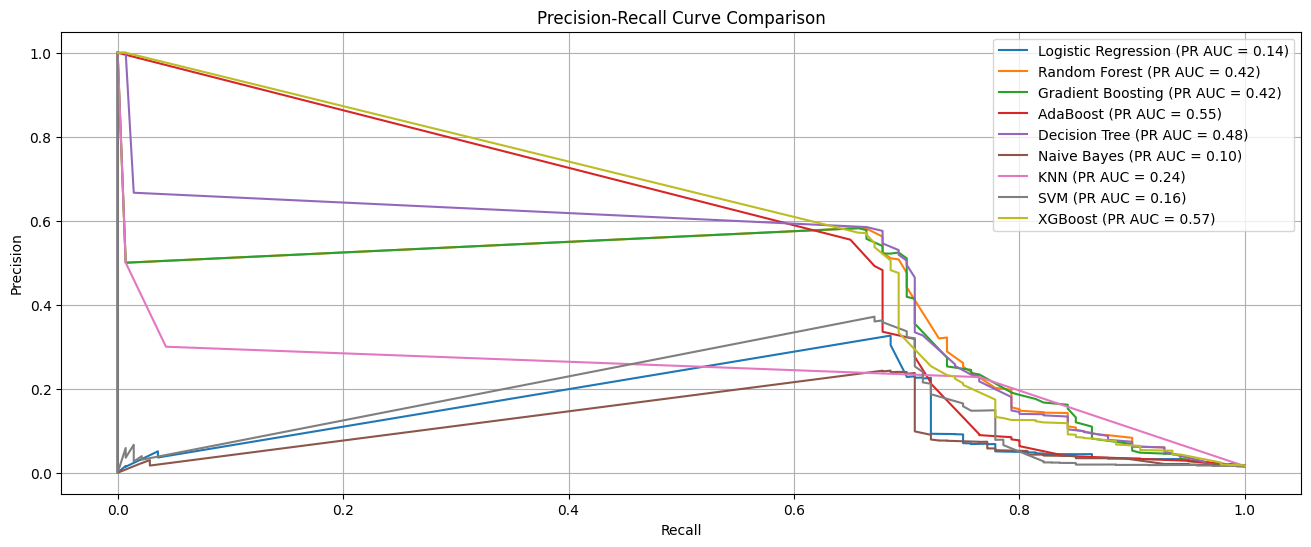



=== Model Evaluation Summary ===
                 Model   ROC AUC    PR AUC
8              XGBoost  0.932854  0.573621
3             AdaBoost  0.898318  0.549397
4        Decision Tree  0.930103  0.480203
1        Random Forest  0.930959  0.423081
2    Gradient Boosting  0.931134  0.422598
6                  KNN  0.862039  0.238633
7                  SVM  0.839273  0.162137
0  Logistic Regression  0.884054  0.140105
5          Naive Bayes  0.858758  0.104415


In [50]:
# Define all models with balanced class settings
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train), use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

plt.figure(figsize=(16, 6))
for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    print(f"\n====== {name} ======")
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    # Print outputs
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"PR AUC Score: {pr_auc:.4f}")

    # Store results
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Confusion Matrix": cm,
        "Classification Report": cr
    })

    # Plot PR Curve
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.2f})")

# Final plot customization
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Store results in DataFrame for comparison
results_df = pd.DataFrame([{
    "Model": r["Model"],
    "ROC AUC": r["ROC AUC"],
    "PR AUC": r["PR AUC"]
} for r in results])

print("\n\n=== Model Evaluation Summary ===")
print(results_df.sort_values(by="PR AUC", ascending=False))


In [51]:
# Base model
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Parameter grid to sample from
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'scale_pos_weight': [1, 5, 10, 20, 50, 100]  # useful for imbalanced datasets
}

# Using f1 score for minority class (high priority tickets)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Randomized search
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_

# Predict and evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("PR-AUC Score:", auc(recall, precision))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Confusion Matrix:
 [[8834   72]
 [  48   92]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8906
           1       0.56      0.66      0.61       140

    accuracy                           0.99      9046
   macro avg       0.78      0.82      0.80      9046
weighted avg       0.99      0.99      0.99      9046

ROC-AUC Score: 0.9163336915722948
PR-AUC Score: 0.5736206842579168


### **Task 1 Conclusion**

After testing multiple models, we selected the **tuned XGBoost model** because it struck the best balance between correctly identifying high-priority tickets and avoiding too many false alarms. While the earlier model had higher recall (it caught more high-priority cases), it did so with very low precision—meaning it made a lot of incorrect guesses.

The tuned model, after hyperparameter tuning, improved the **precision** significantly while maintaining a good recall. This means it’s more reliable in identifying truly high-priority tickets without overpredicting them. So, it's a smarter choice for practical use.


# Task 2: Time Series Forecasting of Incident Volume Quarterly/Annually

In [52]:
df2 = df.copy()

In [53]:
task2 = df.loc[:,['Incident_ID','Open_Time','Category','CI_Cat','CI_Subcat']]

In [54]:
task2.head()

,Incident_ID,Open_Time,Category,CI_Cat,CI_Subcat
0,IM0000004,05-02-2012 13:32,incident,Application,Application
1,IM0000005,12-03-2012 15:44,incident,Application,Application
2,IM0000006,29-03-2012 12:36,request for information,Application,Application
3,IM0000011,17-07-2012 11:49,incident,Application,Application
4,IM0000012,10-08-2012 11:01,incident,Application,Application


In [55]:
def parse_datetime_safe(x):
    for fmt in ['%d/%m/%Y %H:%M:%S', '%d/%m/%Y %H:%M',
                '%m/%d/%Y %H:%M:%S', '%m/%d/%Y %H:%M',
                '%d-%m-%Y %H:%M:%S', '%d-%m-%Y %H:%M']:
        try:
            return datetime.strptime(x, fmt)
        except:
            continue
    return pd.NaT

task2['Open_Time'] = task2['Open_Time'].astype(str).apply(parse_datetime_safe)


##### Extracting Features from Open_Time

In [56]:
task2['Year']=task2['Open_Time'].dt.year
task2['Quarter']=task2['Open_Time'].dt.to_period('Q')
task2['Month']=task2['Open_Time'].dt.month

#### Grouping for Forecasting

In [57]:
# Overall Incident Volume – Quarterly
quarterly =task2.groupby('Quarter').size().reset_index(name='Incident_Count')

In [58]:
#  Overall Incident Volume – Annual
annual = task2.groupby('Year').size().reset_index(name='Incident_Count')

In [59]:
#  Quarterly Volume by CI_Cat
quarterly_by_cat = task2.groupby(['Quarter','CI_Cat']).size().reset_index(name='Incident_Count')

In [60]:
# Quarterly Volume by CI_Subcat
quarterly_by_subcat = task2.groupby(['Quarter','CI_Subcat']).size().reset_index(name='Incident_Count')

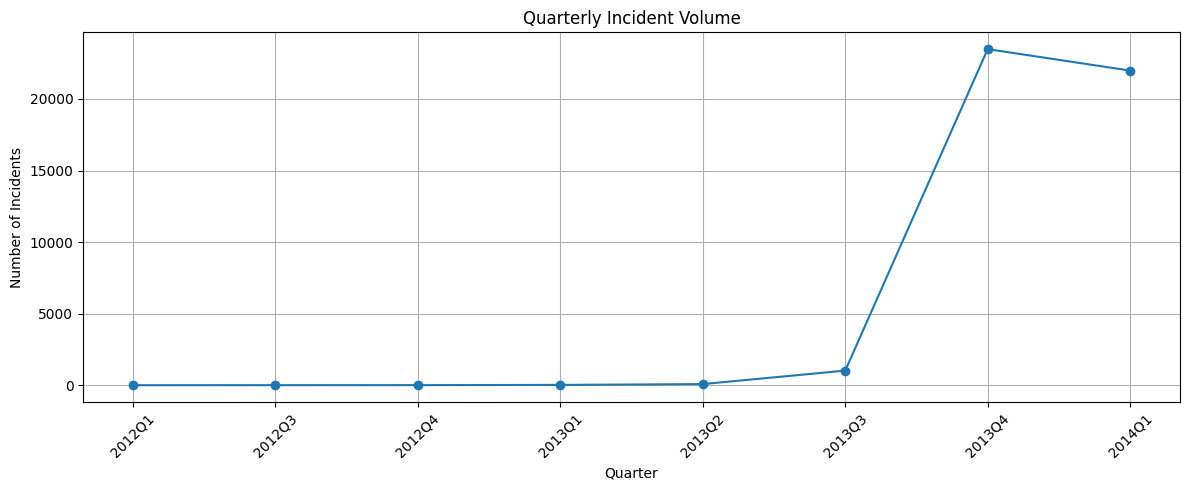

In [61]:
# Quarterly Incident Volume
plt.figure(figsize=(12,5))
plt.plot(quarterly['Quarter'].astype(str),quarterly['Incident_Count'],marker='o')
plt.title('Quarterly Incident Volume')
plt.xlabel('Quarter')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

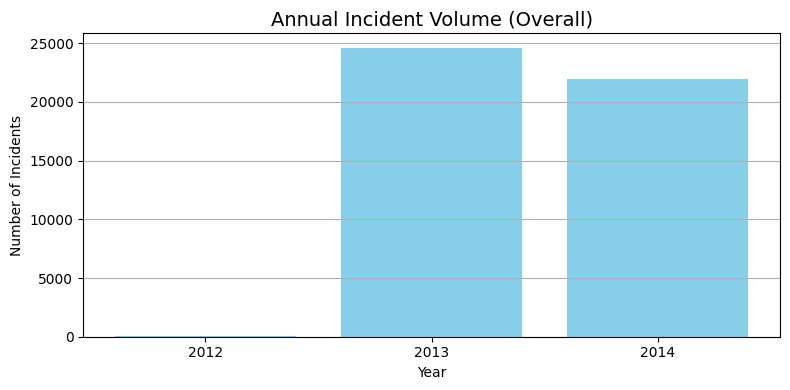

In [62]:
# Annual Incident Volume (Overall)
plt.figure(figsize=(8, 4))
plt.bar(annual['Year'], annual['Incident_Count'], color='skyblue')
plt.title('Annual Incident Volume (Overall)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(annual['Year'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


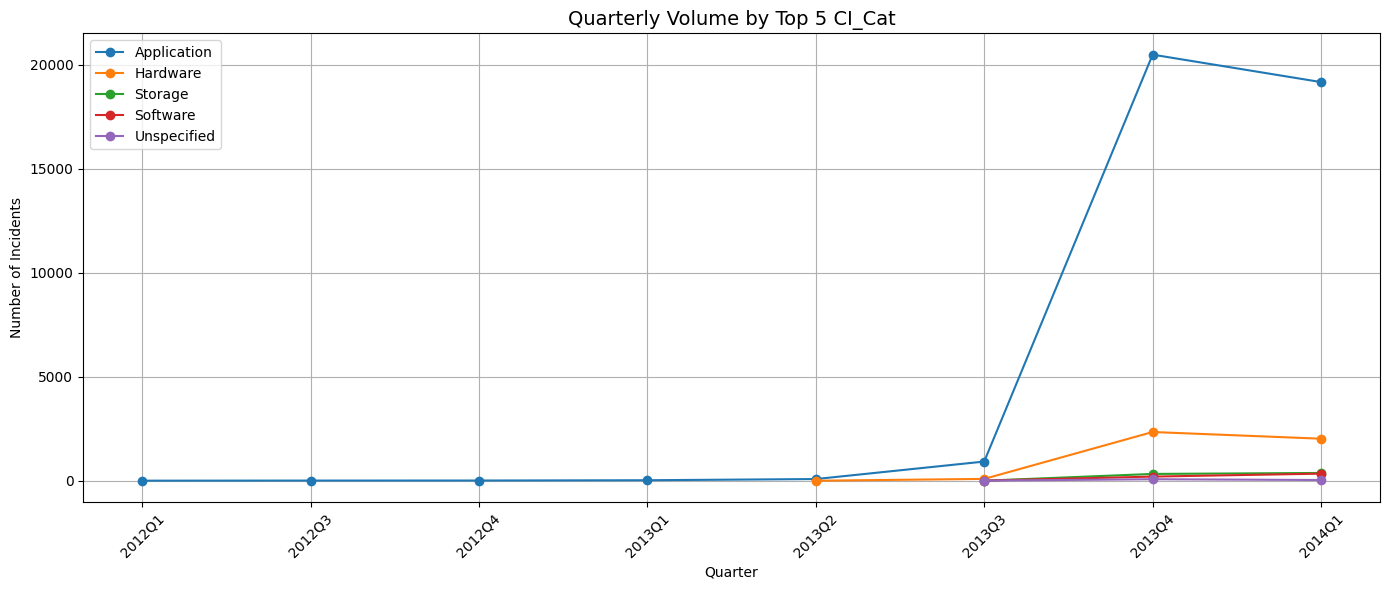

In [63]:
# Quarterly Volume by Top 5 CI_Cat
top5_cats = task2['CI_Cat'].value_counts().nlargest(5).index
filtered_cat = quarterly_by_cat[quarterly_by_cat['CI_Cat'].isin(top5_cats)]

plt.figure(figsize=(14, 6))
for cat in top5_cats:
    subset = filtered_cat[filtered_cat['CI_Cat'] == cat]
    plt.plot(subset['Quarter'].astype(str), subset['Incident_Count'], marker='o', label=cat)

plt.title('Quarterly Volume by Top 5 CI_Cat', fontsize=14)
plt.xlabel('Quarter')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




After analyzing the incident data quarterly and annually, we observed that most of the volume is concentrated from Q3 2013 onward. The earlier periods have little to no data, making the time series incomplete and inconsistent.

Due to only 2–3 meaningful data points with actual volume, traditional forecasting models like ARIMA or Prophet are not applicable. Time-series forecasting requires at least 8–12 consistent periods to detect trends or seasonality, which is not available here.




#### Modelling

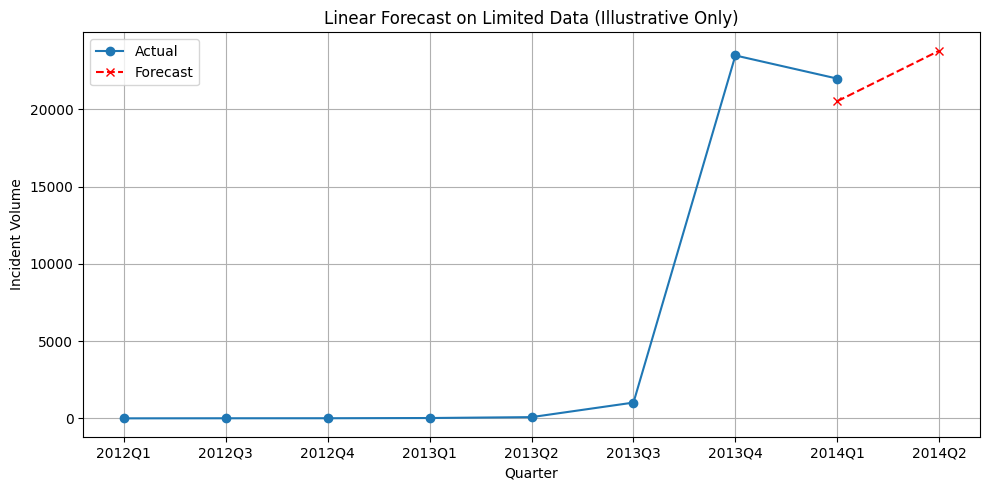

In [64]:
# Use the correctly prepared DataFrame
quarterly['Time_Index'] = np.arange(len(quarterly))

X = quarterly[['Time_Index']]  
y = quarterly[['Incident_Count']]  

# Fit model
model = LinearRegression()
model.fit(X, y)

# Forecast next 2 quarters
future_index = np.arange(len(quarterly), len(quarterly)+2).reshape(-1, 1)
forecast = model.predict(future_index)

# Plot actual + forecast
plt.figure(figsize=(10, 5))
plt.plot(quarterly['Quarter'].astype(str), y, marker='o', label='Actual')
future_quarters = [f'Q{q}' for q in range(2, 4)]  
plt.plot(['2014Q1', '2014Q2'], forecast, marker='x', linestyle='--', color='red', label='Forecast')
plt.title('Linear Forecast on Limited Data (Illustrative Only)')
plt.xlabel('Quarter')
plt.ylabel('Incident Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


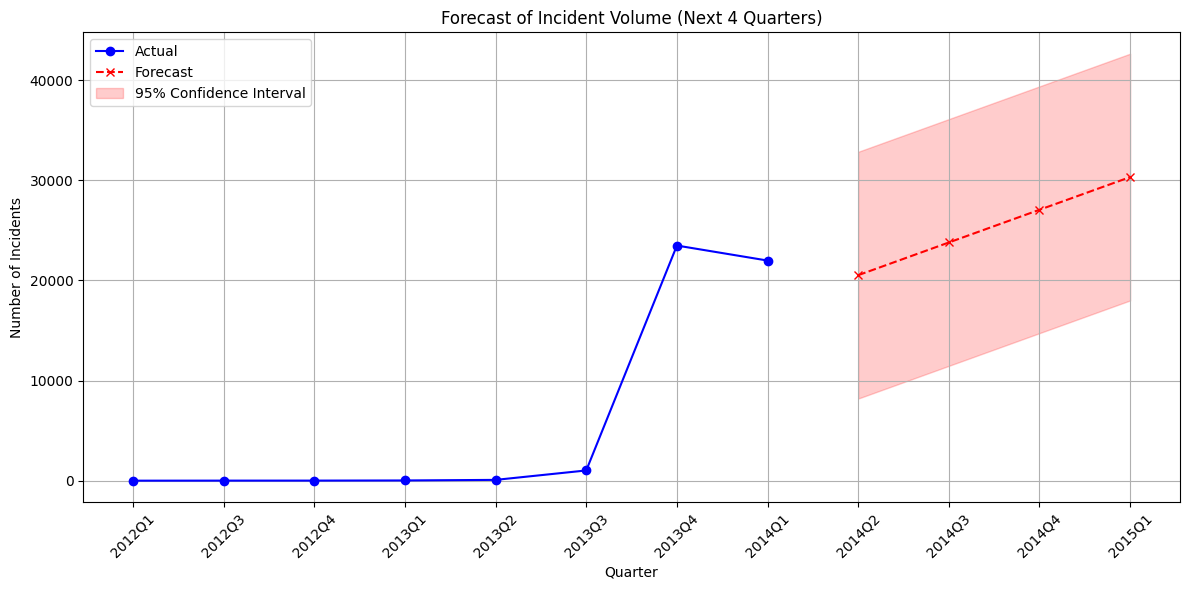

In [65]:
# Add time index
quarterly['Time_Index'] = np.arange(len(quarterly))
X = quarterly[['Time_Index']]
y = quarterly[['Incident_Count']]

# Fit model
model = LinearRegression()
model.fit(X, y)

# Predict on training data to estimate residuals (error)
y_pred = model.predict(X)
residuals = y.values.flatten() - y_pred.flatten()
std_error = np.std(residuals)

# Forecast next 4 quarters
future_index = np.arange(len(quarterly), len(quarterly) + 4).reshape(-1, 1)
forecast = model.predict(future_index)

# Create confidence intervals (95%)
ci_upper = forecast.flatten() + 1.96 * std_error
ci_lower = forecast.flatten() - 1.96 * std_error

# Prepare timeline
historical_quarters = quarterly['Quarter'].astype(str).tolist()
future_quarters = pd.period_range(start=quarterly['Quarter'].iloc[-1] + 1, periods=4, freq='Q').astype(str).tolist()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(historical_quarters, y, marker='o', label='Actual', color='blue')
plt.plot(future_quarters, forecast, marker='x', linestyle='--', color='red', label='Forecast')

# Confidence interval shading
plt.fill_between(future_quarters, ci_lower, ci_upper, color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('Forecast of Incident Volume (Next 4 Quarters)')
plt.xlabel('Quarter')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Task 2 Conclusion: Forecasting Incident Volume

We analyzed quarterly and annual incident volume trends from the dataset. Reliable data was available only from Q3 2013 onward, giving us a very limited number of usable data points for time series forecasting.

To demonstrate possible trends, we fit a simple linear regression model to the recent data and forecasted incident volume for the next 4 quarters. A 95% confidence interval was added to reflect uncertainty due to the limited historical data.

> **Note**: The forecast is illustrative only and not statistically robust due to insufficient historical data. A more accurate model would require at least 8–12 consistent quarters of valid data.

We recommend ABC Tech focus on improving data capture consistency moving forward to enable more reliable forecasting.


# Task 3: Auto-tagging Tickets

In [66]:
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change,Related_Interaction_flag,Related_Change_flag
0,SUB000508,Application,Application,WBS000162,IM0000004,Closed,4,4,4,0.601292,incident,KM0000553,closed,26.0,05-02-2012 13:32,,04-11-2013 13:50,04-11-2013 13:51,NaN,Other,1.0,SD0000007,2.0,NaN,,single,none
1,WBA000124,Application,Application,WBS000088,IM0000005,Closed,3,3,3,0.415050,incident,KM0000611,closed,33.0,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,NaN,Software,1.0,SD0000011,1.0,NaN,,single,none
2,DTA000024,Application,Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551,request for information,KM0000339,closed,3.0,29-03-2012 12:36,,13-01-2014 15:12,13-01-2014 15:13,NaN,Designed behavior,1.0,SD0000017,NaN,NaN,,single,none
3,WBA000124,Application,Application,WBS000088,IM0000011,Closed,4,4,4,0.642927,incident,KM0000611,closed,13.0,17-07-2012 11:49,,14-11-2013 09:31,14-11-2013 09:31,NaN,User/Operator error,1.0,SD0000025,NaN,NaN,,single,none
4,WBA000124,Application,Application,WBS000088,IM0000012,Closed,4,4,4,0.345258,incident,KM0000611,closed,2.0,10-08-2012 11:01,,08-11-2013 13:55,08-11-2013 13:55,NaN,Other,1.0,SD0000029,NaN,NaN,,single,none


In [67]:
df3 = df.copy()

In [68]:
task3 = df3.copy()
useful_cols = ['CI_Cat', 'CI_Subcat', 'WBS', 'Category', 'Priority']
task3 = task3[useful_cols]

In [69]:
# Cleaning columns
categorical_cols = ['CI_Subcat', 'WBS', 'Category']
ordinal_col = 'Priority'

# Clean Priority column
task3 = task3[task3['Priority'] != 'NA']
task3['Priority'] = task3['Priority'].astype(int)
task3 = task3[task3['Priority'] != 1]  # remove Priority 1 rows

##### Encoding

In [70]:
# Label Encoders
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    task3[col] = le.fit_transform(task3[col])
    le_dict[col] = le

# Label Encoder for CI_Cat
task3['CI_Cat_Original'] = task3['CI_Cat']  # Backup
le_ci_cat = LabelEncoder()
task3['CI_Cat'] = le_ci_cat.fit_transform(task3['CI_Cat'])

In [71]:
# Ordinal encoding
priority_order = [[2, 3, 4, 5]]
oe_priority = OrdinalEncoder(categories=priority_order)
task3['Priority'] = oe_priority.fit_transform(task3[['Priority']]).astype(int)


##### Modelling

In [72]:
def train_best_model(X, y, categorical_feature_indices, task_name=''):
    if len(categorical_feature_indices) == X.shape[1]:
        categorical_feature_indices = categorical_feature_indices[:-1]  # Ensure at least one numeric col

    # Handle imbalance with SMOTENC
    smote = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, k_neighbors=3)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Stratified split to preserve label distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )

    best_model = None
    best_score = 0
    best_model_name = None
    num_classes = len(np.unique(y))

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            objective='multi:softmax',
            num_class=num_classes,
            random_state=42
        )

    }

    
 

    print(f"\nModel Evaluation for Task: {task_name}")
    print("=" * 40)

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred, digits=3, output_dict=True)
        macro_f1 = report['macro avg']['f1-score']
        weighted_f1 = report['weighted avg']['f1-score']
        acc = report['accuracy']

        print(f"\n{name} Results:")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, digits=3))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(f"Accuracy: {acc:.4f}")
        print(f"Macro F1 Score: {macro_f1:.4f}")
        print(f"Weighted F1 Score: {weighted_f1:.4f}")

        # Use macro F1 for selection
        if macro_f1 > best_score:
            best_score = macro_f1
            best_model = model
            best_model_name = name

    print(f"\nBest Model for {task_name}: **{best_model_name}** with Macro F1 Score = {best_score:.4f}")
    return best_model


In [73]:
# Train Priority Model
X_priority = task3[['CI_Subcat', 'WBS', 'Category']]
y_priority = task3['Priority']
priority_model = train_best_model(X_priority, y_priority, categorical_feature_indices=[0, 1], task_name='Priority')


Model Evaluation for Task: Priority

Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0      0.479     0.551     0.513      4544
           1      0.338     0.201     0.252      4543
           2      0.527     0.894     0.663      4544
           3      0.895     0.500     0.642      4543

    accuracy                          0.537     18174
   macro avg      0.560     0.537     0.517     18174
weighted avg      0.560     0.537     0.517     18174

Confusion Matrix:
 [[2506 1108  890   40]
 [2112  913 1401  117]
 [ 233  138 4063  110]
 [ 376  540 1355 2272]]
Accuracy: 0.5367
Macro F1 Score: 0.5175
Weighted F1 Score: 0.5175

Decision Tree Results:
Classification Report:
              precision    recall  f1-score   support

           0      0.518     0.671     0.585      4544
           1      0.496     0.365     0.421      4543
           2      0.774     0.902     0.833      4544
           3      0.855     0.685

In [74]:
# Train CI_Cat Model
X_ci_cat = task3[['CI_Subcat', 'WBS', 'Category', 'Priority']]
y_ci_cat = task3['CI_Cat']
ci_cat_model = train_best_model(X_ci_cat, y_ci_cat, categorical_feature_indices=[0, 1, 2], task_name='CI_Cat')


Model Evaluation for Task: CI_Cat

Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0      0.642     0.967     0.772      7919
           1      0.260     0.226     0.242      7919
           2      0.306     0.547     0.392      7920
           3      0.000     0.000     0.000      7920
           4      0.333     0.249     0.285      7920
           5      0.371     0.405     0.387      7920

    accuracy                          0.399     47518
   macro avg      0.319     0.399     0.346     47518
weighted avg      0.319     0.399     0.346     47518

Confusion Matrix:
 [[7656  162   69    0    3   29]
 [ 891 1789 1742    0  849 2648]
 [ 686  985 4329    0 1128  792]
 [ 787  904 4415    0  997  817]
 [ 939 1696 2169    0 1972 1144]
 [ 967 1341 1435    0  972 3205]]
Accuracy: 0.3988
Macro F1 Score: 0.3463
Weighted F1 Score: 0.3463

Decision Tree Results:
Classification Report:
              precision    recall  f1-

In [75]:
# Auto-Tagging Function

def autotag(df):
    df_copy = df.copy()

    # Encode categorical columns
    for col in categorical_cols:
        df_copy[col] = le_dict[col].transform(df_copy[col])

    # Predict Priority
    X_pri = df_copy[['CI_Subcat', 'WBS', 'Category']]
    pri_preds_encoded = priority_model.predict(X_pri)
    pri_preds_decoded = [priority_order[0][i] for i in pri_preds_encoded]
    df_copy['Priority'] = pri_preds_encoded

    # Predict CI_Cat
    X_cat = df_copy[['CI_Subcat', 'WBS', 'Category', 'Priority']]
    ci_preds_encoded = ci_cat_model.predict(X_cat)
    ci_preds_decoded = le_ci_cat.inverse_transform(ci_preds_encoded)

    df_result = df.copy()
    df_result['Predicted_Priority'] = pri_preds_decoded
    df_result['Predicted_CI_Cat'] = ci_preds_decoded
    return df_result

### Task 3 – Priority Prediction Conclusion

- The Decision Tree model emerged as the best performer for predicting ticket priority, achieving a macro F1 score of 0.65. 
- It provided consistent results across all four priority classes, outperforming Logistic Regression and slightly edging out ensemble methods like XGBoost and Random Forest.  
- This model can support faster and more reliable triaging of incoming tickets.

---

### Task 3 – CI_Cat Prediction Conclusion

- For predicting CI_Cat categories, XGBoost delivered the best balance across all six classes with a macro F1 score of 0.47.
- Tree-based models significantly outperformed Logistic Regression, especially in handling imbalanced and overlapping categories. While the accuracy isn't high due to the complexity of the problem, the model offers a solid base for automating CI tagging and improving ticket classification workflows.


# Task 4 (Part 1): Predicting Request For Change (RFC)

In [76]:
df4=df.copy()

In [77]:
# Selected predictive features
features = ['CI_Cat', 'CI_Subcat', 'WBS', 'Priority', 'No_of_Reassignments','Related_Change_flag']
task4 = df4[features]

In [78]:
task4.head()

,CI_Cat,CI_Subcat,WBS,Priority,No_of_Reassignments,Related_Change_flag
0,Application,Application,WBS000162,4,26.0,none
1,Application,Application,WBS000088,3,33.0,none
2,Application,Application,WBS000092,NA,3.0,none
3,Application,Application,WBS000088,4,13.0,none
4,Application,Application,WBS000088,4,2.0,none


In [79]:
task4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CI_Cat               46606 non-null  object 
 1   CI_Subcat            46606 non-null  object 
 2   WBS                  46606 non-null  object 
 3   Priority             46606 non-null  object 
 4   No_of_Reassignments  46605 non-null  float64
 5   Related_Change_flag  46606 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.1+ MB


##### Data Preprocessing

In [80]:
# Removing rows with priority = 'NA' and coverting priority column into integer
task4 = task4[task4['Priority'] != 'NA']
task4['Priority'] = task4['Priority'].astype(int)

In [81]:
task4['Related_Change_flag'].unique()


array(['none', 'single', 'multiple'], dtype=object)

In [82]:
# Changing Related_change_flag values into binary 'change' and 'none'
def change_related_change_flag(x):
    if x in ['multiple','single']:
        return 'change'
    else:
        return 'none'
    
task4['Related_Change_flag'] = task4['Related_Change_flag'].apply(change_related_change_flag) 


In [83]:
task4['Related_Change_flag'].value_counts(dropna=False)


Related_Change_flag
none      44701
change      525
Name: count, dtype: int64

In [84]:
# Label Encoding
le = LabelEncoder()
lab_col = ['CI_Cat','CI_Subcat','WBS'] 
for col in lab_col:
    task4[col] = le.fit_transform(task4[col])

In [85]:
# Ordinal Encoding
priority_order = [[1,2,3,4,5]]
oe = OrdinalEncoder(categories=priority_order)
task4['Priority'] = oe.fit_transform(task4[['Priority']]).astype(int)

In [86]:
task4['Related_Change_flag_binary'] = task4['Related_Change_flag'].map({'none': 0, 'change': 1})


In [87]:
task4['Related_Change_flag_binary'].value_counts()

Related_Change_flag_binary
0    44701
1      525
Name: count, dtype: int64

In [88]:
task4= task4.drop('Related_Change_flag',axis=1)

In [89]:
task4.head()

,CI_Cat,CI_Subcat,WBS,Priority,No_of_Reassignments,Related_Change_flag_binary
0,0,0,136,3,26.0,0
1,0,0,70,2,33.0,0
3,0,0,70,3,13.0,0
4,0,0,70,3,2.0,0
5,0,0,70,3,4.0,0


In [90]:
task4['No_of_Reassignments'] = task4['No_of_Reassignments'].fillna(task4['No_of_Reassignments'].median())


In [91]:
# Splitting X and y
X = task4.drop(columns=['Related_Change_flag_binary'])
y = task4['Related_Change_flag_binary']

In [92]:
# smote
smote = SMOTENC(categorical_features=[0,1,2], random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [93]:
# Train_Test_Split
X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [94]:
# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [95]:
task4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45226 entries, 0 to 46605
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Cat                      45226 non-null  int64  
 1   CI_Subcat                   45226 non-null  int64  
 2   WBS                         45226 non-null  int64  
 3   Priority                    45226 non-null  int64  
 4   No_of_Reassignments         45226 non-null  float64
 5   Related_Change_flag_binary  45226 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 2.4 MB


In [96]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000,random_state=42,class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced',random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced',random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss' ,random_state=42)
}

results = {}

for name,model in models.items():
    print(f'\n{name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('Classification Report:')
    print(classification_report(y_test,y_pred, digits=3))

    print('Confusion Matrix:')
    print(confusion_matrix(y_test,y_pred))

    f1 = f1_score(y_test,y_pred)
    roc = roc_auc_score(y_test,y_pred)
    print(f'F1 Score: {f1:.4f} | ROC-AUC: {roc:.4f}')

    results[name]={'f1':f1,'roc_auc':roc}
    




Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0      0.631     0.511     0.565      9059
           1      0.580     0.693     0.632      8822

    accuracy                          0.601     17881
   macro avg      0.606     0.602     0.598     17881
weighted avg      0.606     0.601     0.598     17881

Confusion Matrix:
[[4628 4431]
 [2704 6118]]
F1 Score: 0.6317 | ROC-AUC: 0.6022

Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0      0.945     0.737     0.828      9059
           1      0.780     0.956     0.859      8822

    accuracy                          0.845     17881
   macro avg      0.862     0.847     0.844     17881
weighted avg      0.864     0.845     0.843     17881

Confusion Matrix:
[[6676 2383]
 [ 387 8435]]
F1 Score: 0.8590 | ROC-AUC: 0.8465

Random Forest
Classification Report:
              precision    recall  f1-score   support

           

In [97]:
best_model_name = max(results, key=lambda k: results[k]['f1'])
print(f"\nBest Model (F1 Score): {best_model_name}")


Best Model (F1 Score): Random Forest


In [98]:
df4['Closure_Code'].value_counts()

Closure_Code
Other                  16470
Software               13027
User/Operator error     5858
Designed behavior       3530
Hardware                2999
Data                    2209
Unknown                 2050
Inquiry-related          452
Other rare                11
Name: count, dtype: int64

In [99]:
df4['No_of_Related_Changes'].value_counts()

No_of_Related_Changes
1.0    536
2.0     21
3.0      2
9.0      1
Name: count, dtype: int64

# Task 4 (Part 2): Predict Closure_Code (possible failure / misconfiguration)

In [100]:
# Remove rows where Closure_Code is missing
task4p2 = df[['CI_Cat', 'CI_Subcat', 'WBS', 'Priority', 'No_of_Reassignments',
         'No_of_Related_Incidents', 'Related_Change_flag',
            'Closure_Code']].copy()

In [101]:
# Drop rows with missing target
task4p2 = task4p2[task4p2['Closure_Code'].notna()]

In [102]:
task4p2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CI_Cat                   46606 non-null  object 
 1   CI_Subcat                46606 non-null  object 
 2   WBS                      46606 non-null  object 
 3   Priority                 46606 non-null  object 
 4   No_of_Reassignments      46605 non-null  float64
 5   No_of_Related_Incidents  1222 non-null   float64
 6   Related_Change_flag      46606 non-null  object 
 7   Closure_Code             46606 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.8+ MB


In [103]:
# Removing rows with priority = 'NA' and coverting priority column into integer
task4p2 = task4p2[task4p2['Priority'] != 'NA']
task4p2['Priority'] = task4p2['Priority'].astype(int)

In [104]:
# Imputing missing values
task4p2['No_of_Reassignments'].fillna(task4p2['No_of_Reassignments'].median(), inplace=True)
task4p2['No_of_Related_Incidents'].fillna(0, inplace=True)

In [105]:
# Label Encoding

categorical_cols = ['CI_Cat', 'CI_Subcat', 'WBS', 'Related_Change_flag','Closure_Code']
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    task4p2[col] = le.fit_transform(task4p2[col])
    le_dict[col] = le


In [106]:
# Ordinal Encoding
priority_order = [[1, 2, 3, 4, 5]]
oe_priority = OrdinalEncoder(categories=priority_order)
task4p2[['Priority']] = oe_priority.fit_transform(task4p2[['Priority']]).astype(int)


In [107]:
X = task4p2.drop(columns=['Closure_Code'])
y = task4p2['Closure_Code']


##### Smote

In [108]:
smote = SMOTENC(categorical_features=[0,1,2,3,6], random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


##### Train_test_split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)


##### Scaling

In [110]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


##### Modelling

In [111]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Macro F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")



Logistic Regression
Classification Report:
                      precision    recall  f1-score   support

               Data       0.22      0.10      0.14      3222
  Designed behavior       0.15      0.16      0.16      3222
           Hardware       0.59      0.61      0.60      3222
    Inquiry-related       0.31      0.58      0.41      3222
              Other       0.17      0.08      0.10      3222
         Other rare       0.94      1.00      0.97      3222
           Software       0.38      0.04      0.07      3222
            Unknown       0.43      0.20      0.27      3222
User/Operator error       0.22      0.54      0.31      3222

           accuracy                           0.37     28998
          macro avg       0.38      0.37      0.34     28998
       weighted avg       0.38      0.37      0.34     28998

Confusion Matrix:
 [[ 330  753  171  410  234   43   26   81 1174]
 [ 315  518  146  889  234   19   15   97  989]
 [  26  121 1953  184   59   72   15  258  5

### Task 4 Conclusion: Predicting RFCs & Closure Codes

#### Part 1: Predicting RFCs (Request for Change)
We built models to predict whether a ticket is linked to an RFC (i.e., a change request).

**Best Model:** Random Forest  
**Accuracy:** ~84%  
**Macro F1 Score:** ~0.86  
**ROC-AUC:** ~0.84

After balancing classes using SMOTE, tree-based models like Random Forest and XGBoost performed the best.  
These models can help detect if a change was involved in an incident, even before it's manually tagged.

---

#### Part 2: Predicting Closure Code (Reason for Ticket Closure)
We trained models to auto-classify the final resolution of a ticket using ticket attributes.

**Best Model:** XGBoost  
**Accuracy:** 62%  
**Macro F1 Score:** 0.62

Tree-based models outperformed Logistic Regression significantly.  
XGBoost gave more balanced predictions across closure types like "Hardware", "Software", and "User Error".  
Useful for automatically tagging closure codes, saving manual effort.

---